In [2]:
# Bibliotecas
import pandas as pd
import plotnine as p9
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Coletar Dados
dados_brutos_ipca = pd.read_json("https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/2265,2266/p/all/d/v2265%202,v2266%2013?formato=json")
dados_brutos_desemprego = pd.read_json("https://apisidra.ibge.gov.br/values/t/6381/n1/all/v/4099/p/all/d/v4099%201?formato=json")
dados_brutos_ipca
dados_brutos_desemprego

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Trimestre Móvel (Código),Trimestre Móvel
1,1,Brasil,2,%,8.0,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201203,jan-fev-mar 2012
2,1,Brasil,2,%,7.8,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201204,fev-mar-abr 2012
3,1,Brasil,2,%,7.7,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201205,mar-abr-mai 2012
4,1,Brasil,2,%,7.6,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201206,abr-mai-jun 2012
...,...,...,...,...,...,...,...,...,...,...,...
150,1,Brasil,2,%,6.6,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",202408,jun-jul-ago 2024
151,1,Brasil,2,%,6.4,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",202409,jul-ago-set 2024
152,1,Brasil,2,%,6.2,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",202410,ago-set-out 2024
153,1,Brasil,2,%,6.1,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",202411,set-out-nov 2024


In [5]:
# Tratamento de Dados

# Tratamento de Dados IPCA
dados_tratados_ipca = (
    dados_brutos_ipca
    .rename(columns={"V": "ipca", "D3C": "data"})
    .query("ipca not in ['Valor', '...']")
    .assign(
        data = lambda x: pd.to_datetime(x.data, format="%Y%m"),
        ipca = lambda x: x.ipca.astype(float)
    )
    .filter(["data", "ipca", "MN"])
    .query("data >= @pd.to_datetime('2004-01-01') and MN == '%'")
)
dados_tratados_ipca

,data,ipca,MN
290,2004-01-01,7.71,%
291,2004-02-01,6.69,%
292,2004-03-01,5.89,%
293,2004-04-01,5.26,%
294,2004-05-01,5.15,%
...,...,...,...
538,2024-09-01,4.42,%
539,2024-10-01,4.76,%
540,2024-11-01,4.87,%
541,2024-12-01,4.83,%


In [6]:
## Tratamento de Dados Desemprego
dados_tratados_desemprego = (
    dados_brutos_desemprego
    .rename(columns={"V": "desemprego", "D3C": "data"})
    .query("desemprego not in ['Valor', '...']")
    .assign(
        data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
        desemprego = lambda x: x.desemprego.astype(float)
    )
    .filter(["data", "desemprego"])
)
dados_tratados_desemprego

,data,desemprego
1,2012-03-01,8.0
2,2012-04-01,7.8
3,2012-05-01,7.7
4,2012-06-01,7.6
5,2012-07-01,7.5
...,...,...
150,2024-08-01,6.6
151,2024-09-01,6.4
152,2024-10-01,6.2
153,2024-11-01,6.1


In [7]:
## Cruzando as Tabelas
dados_cruzados = (
    dados_tratados_ipca
    .set_index("data")
    .join(other = dados_tratados_desemprego.set_index("data"), how = "inner")
    .reset_index()
)
dados_cruzados

,data,ipca,MN,desemprego
0,2012-03-01,5.24,%,8.0
1,2012-04-01,5.10,%,7.8
2,2012-05-01,4.99,%,7.7
3,2012-06-01,4.92,%,7.6
4,2012-07-01,5.20,%,7.5
...,...,...,...,...
149,2024-08-01,4.24,%,6.6
150,2024-09-01,4.42,%,6.4
151,2024-10-01,4.76,%,6.2
152,2024-11-01,4.87,%,6.1


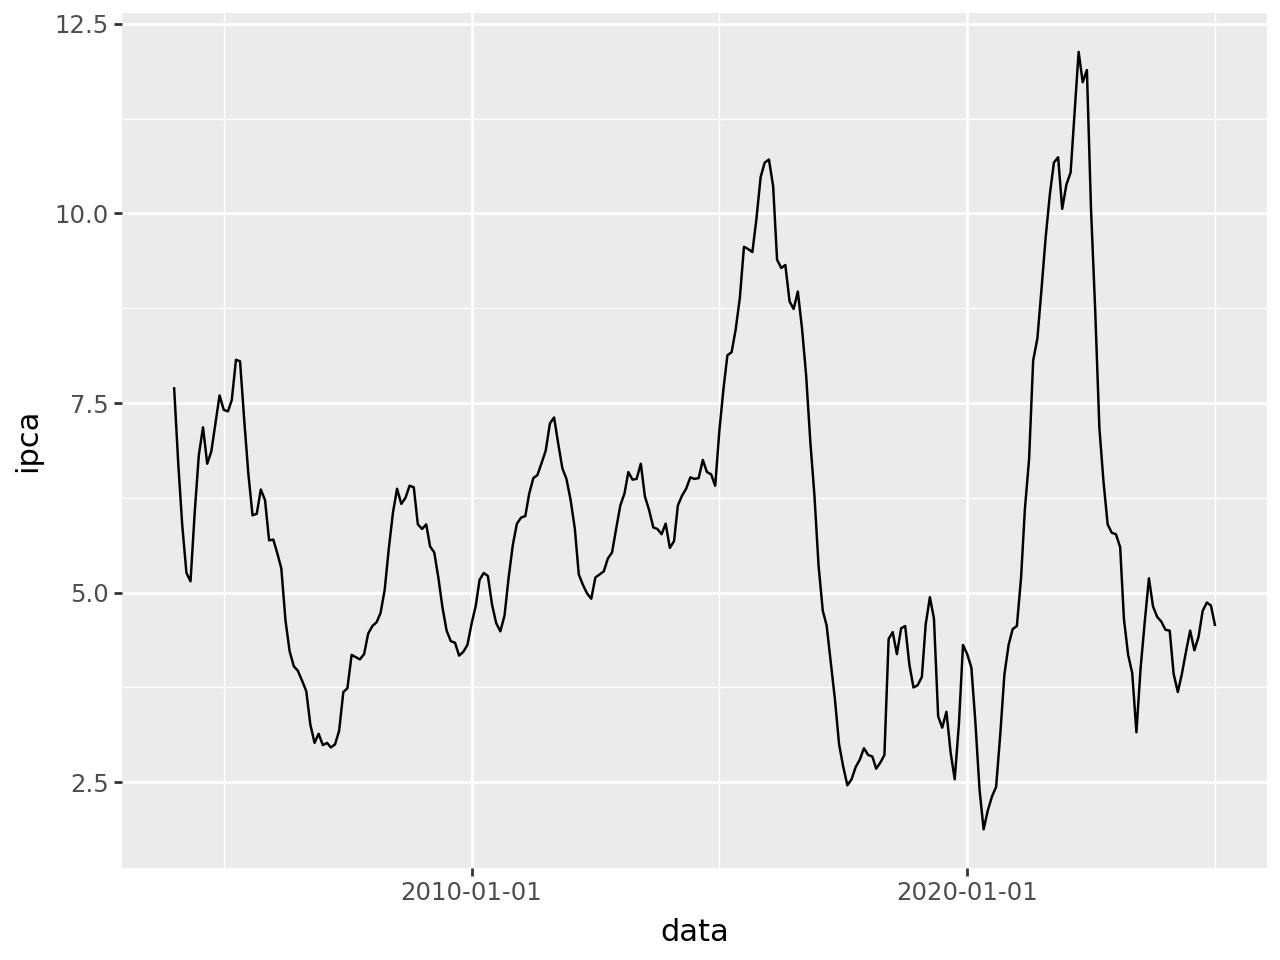

In [8]:
#Análise de Dados

## Como a inflação se comportou no Brasil?
# Como a inflação se comportou no Brasil?
(
    p9.ggplot(dados_tratados_ipca) +
    p9.aes(x = "data", y = "ipca") +
    p9.geom_line()
)

In [9]:
## Qual o período com maiores e menores taxas de inflação?
print(dados_tratados_ipca.set_index("data").sort_values("ipca").iloc[0])
print(dados_tratados_ipca.query("ipca == ipca.max()"))

ipca    1.88
MN         %
Name: 2020-05-01 00:00:00, dtype: object
          data   ipca MN
509 2022-04-01  12.13  %


/usr/local/lib/python3.11/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.


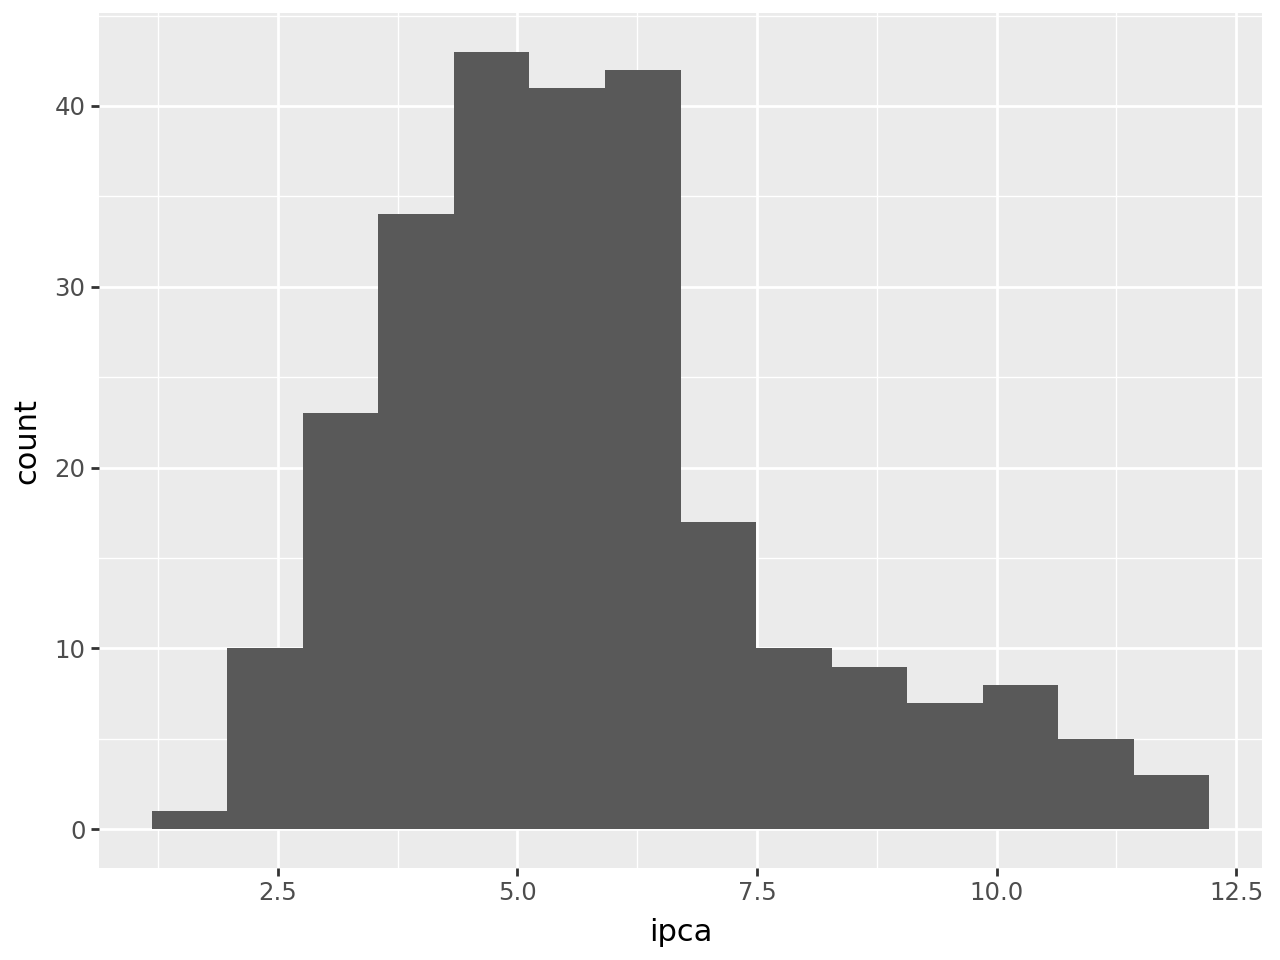

In [10]:
## Qual o valor médio da inflação no Brasil?
dados_tratados_ipca.ipca.describe()

(
    p9.ggplot(dados_tratados_ipca) +
    p9.aes(x = "ipca") +
    p9.geom_histogram()
)

                            OLS Regression Results                            
Dep. Variable:                   ipca   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.341
Date:                Fri, 14 Feb 2025   Prob (F-statistic):             0.0389
Time:                        20:05:49   Log-Likelihood:                -356.23
No. Observations:                 154   AIC:                             716.5
Df Residuals:                     152   BIC:                             722.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4372      0.776      9.585      0.0

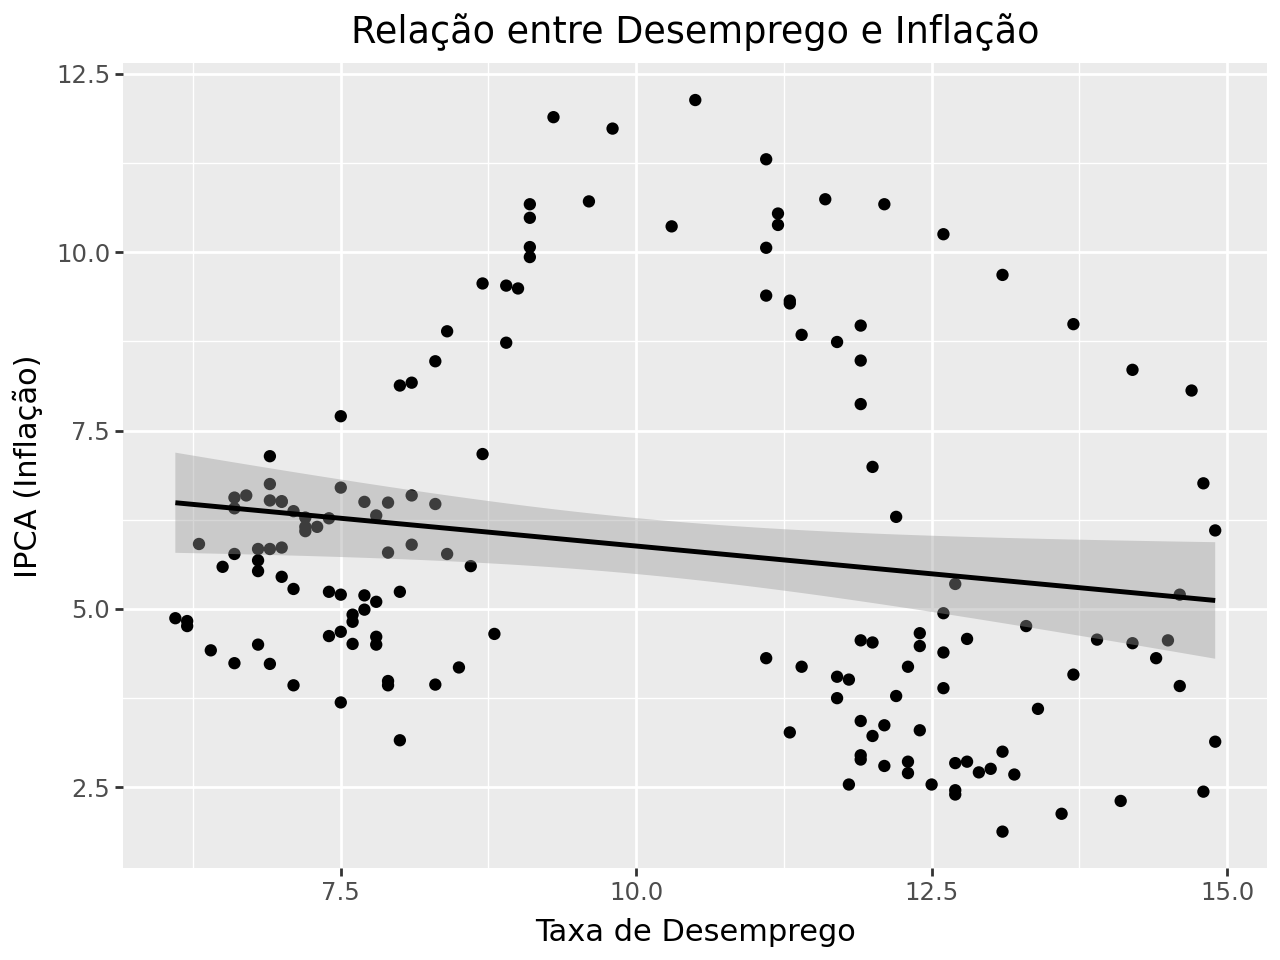

In [11]:
## O que afeta a inflação? Com qual variável ela se relaciona?
modelo = smf.ols("ipca ~ desemprego", data = dados_cruzados).fit()
print(modelo.summary())

(
    p9.ggplot(dados_cruzados) +
    p9.aes(x="desemprego", y="ipca") +
    p9.geom_point() +
    p9.geom_smooth(method = "lm") +
    p9.labs(title="Relação entre Desemprego e Inflação", x="Taxa de Desemprego", y="IPCA (Inflação)")
)

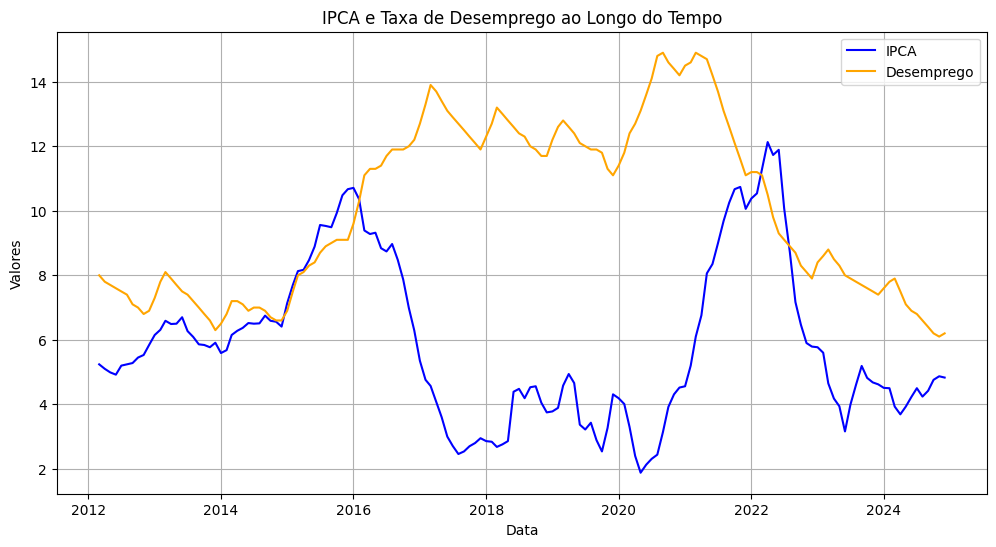

In [12]:
# Gráfico de Comparação IPCA x Desemprego
plt.figure(figsize=(12, 6))
plt.plot(dados_cruzados['data'], dados_cruzados['ipca'], label='IPCA', color='blue')
plt.plot(dados_cruzados['data'], dados_cruzados['desemprego'], label='Desemprego', color='orange')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('IPCA e Taxa de Desemprego ao Longo do Tempo')
plt.legend()
plt.grid(True)